In [19]:
import mne
import os

# load data
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"

raw_dir = os.path.join('..', '..', 'raw')

file_path = os.path.join(raw_dir, resting_state_path)
raw = mne.io.read_raw_eeglab(file_path, preload=True)

n_channels = len(raw.info['ch_names'])

In [21]:
# low pass filter
raw.filter(l_freq=1, h_freq=45, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 s)
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25

<RawEEGLAB | sub-NDARAA396TWZ_task-RestingState_eeg.set, 129 x 205857 (411.7 s), ~202.7 MiB, data loaded>

In [24]:
from asrpy import ASR

asr = ASR(sfreq=raw.info['sfreq'], cutoff=15)
asr.fit(raw)

C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\asrpy\asr_utils.py:124: RuntimeWarning: divide by zero encountered in divide
  cols = nbins / newX[mcurr]
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\asrpy\asr_utils.py:125: RuntimeWarning: invalid value encountered in multiply
  H = newX[:m] * cols
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\asrpy\asr.py:750: RuntimeWarning: invalid value encountered in divide
  wz[ichan] = (Y - mu) / sig
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\asrpy\asr.py:440: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  M = linalg

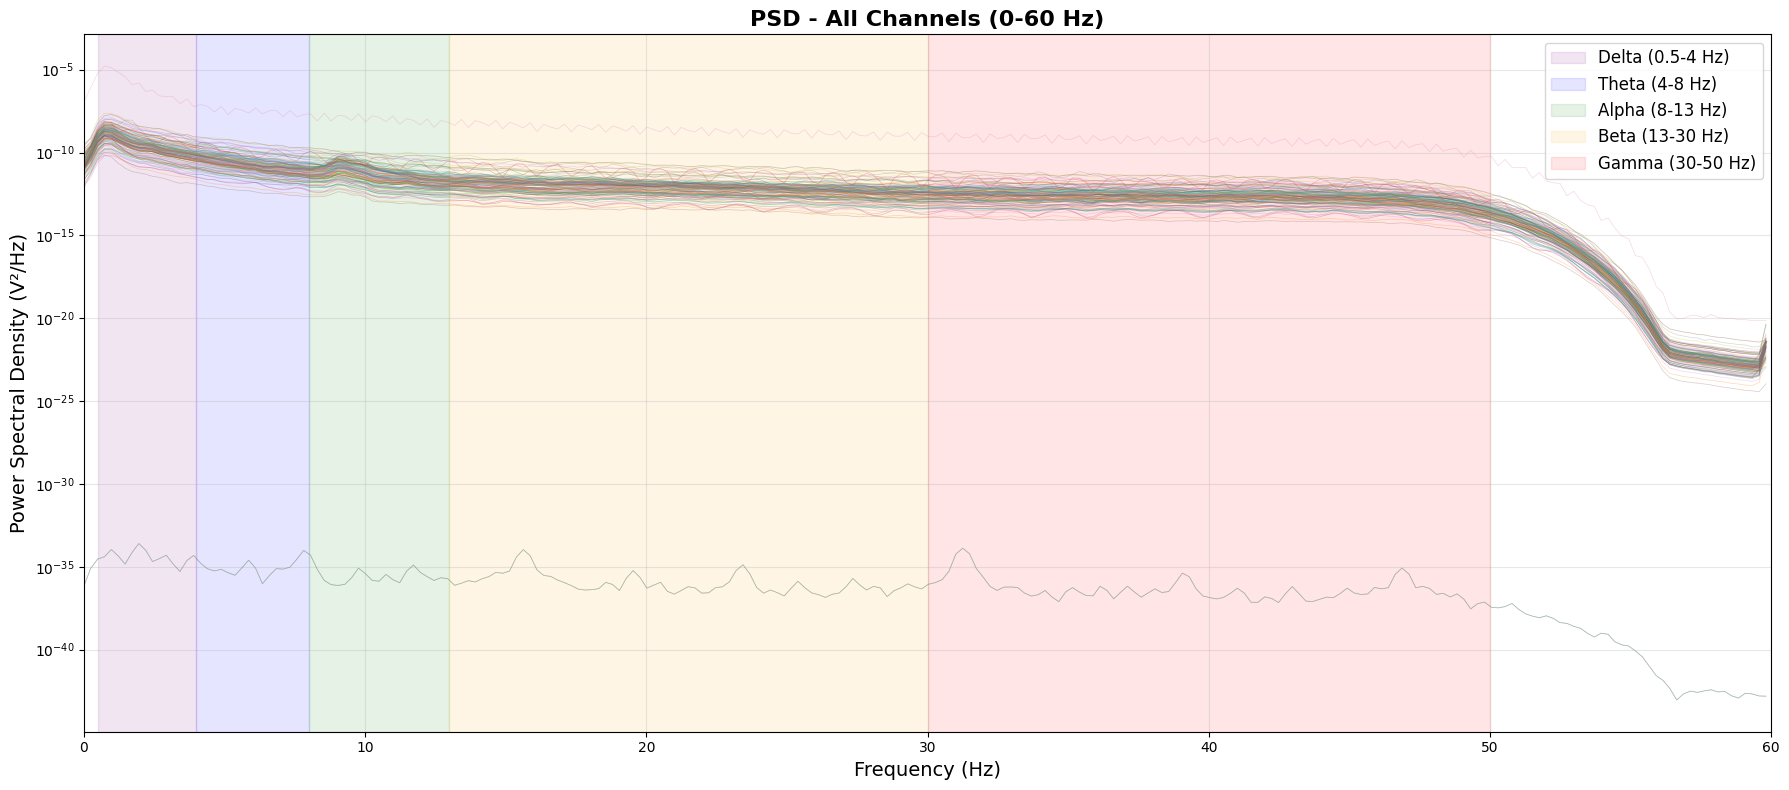

In [25]:
from scipy import signal as sp_signal
import matplotlib.pyplot as plt
import numpy as np

# Get data
data = raw.get_data()

# Create LARGE figure
fig, ax = plt.subplots(figsize=(18, 8))  # Super wide and tall


# Compute and plot PSD for all channels
for i, ch_name in enumerate(raw.ch_names):
    freqs, psd = sp_signal.welch(data[i], fs=raw.info['sfreq'], nperseg=2048)
    
    # Only plot frequencies 0-60 Hz with values > 0
    mask = (freqs >= 0) & (freqs <= 60) & (psd > 0)
    ax.semilogy(freqs[mask], psd[mask], alpha=0.3, linewidth=0.5)

# Make it readable
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.set_ylabel('Power Spectral Density (V²/Hz)', fontsize=14)
ax.set_title('PSD - All Channels (0-60 Hz)', fontsize=16, fontweight='bold')
ax.set_xlim(0, 60)
ax.grid(True, alpha=0.3)

# Add brain wave band markers
ax.axvspan(0.5, 4, alpha=0.1, color='purple', label='Delta (0.5-4 Hz)')
ax.axvspan(4, 8, alpha=0.1, color='blue', label='Theta (4-8 Hz)')
ax.axvspan(8, 13, alpha=0.1, color='green', label='Alpha (8-13 Hz)')
ax.axvspan(13, 30, alpha=0.1, color='orange', label='Beta (13-30 Hz)')
ax.axvspan(30, 50, alpha=0.1, color='red', label='Gamma (30-50 Hz)')

ax.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

In [29]:
# Save cleaned data in different formats

# Ensure the processed directory exists to avoid FileNotFoundError
processed_dir = os.path.join('..', '..', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Option 1: Save as .fif (MNE's native format - RECOMMENDED)
output_path_fif = os.path.join(processed_dir, 'resting_state_cleaned.fif')
raw.save(output_path_fif, overwrite=True)
print(f"✓ Saved as FIF: {output_path_fif}")

# Option 2: Save as .set (EEGLAB format)
output_path_set = os.path.join(processed_dir, 'resting_state_cleaned.set')
mne.export.export_raw(output_path_set, raw, fmt='eeglab', overwrite=True)
print(f"✓ Saved as SET: {output_path_set}")

# Option 3: Save as NumPy array (for GAN or other Python projects)
output_path_npy = os.path.join(processed_dir, 'resting_state_cleaned.npy')
np.save(output_path_npy, raw.get_data())
print(f"✓ Saved as NPY: {output_path_npy}")

# Also save channel names and sampling frequency
metadata = {
    'ch_names': raw.ch_names,
    'sfreq': raw.info['sfreq'],
    'n_channels': len(raw.ch_names),
    'n_times': raw.n_times
}
metadata_path = os.path.join(processed_dir, 'resting_state_metadata.npy')
np.save(metadata_path, metadata)
print(f"✓ Saved metadata: {metadata_path}")

print("\n" + "="*60)
print("SAVED CLEANED DATA")
print("="*60)
print(f"Channels: {len(raw.ch_names)}")
print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.1f} seconds")
print(f"Data shape: {raw.get_data().shape}")
print("="*60)

Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned.fif
Overwriting existing file.
Writing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned.fif
Overwriting existing file.


C:\Users\JINQI\AppData\Local\Temp\ipykernel_30796\2567269056.py:9: RuntimeWarning: This filename (c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_path_fif, overwrite=True)


Closing c:\Users\JINQI\Coursework\DATA495\notebooks\joseph-nb\..\..\processed\resting_state_cleaned.fif
[done]
[done]
✓ Saved as FIF: ..\..\processed\resting_state_cleaned.fif
✓ Saved as FIF: ..\..\processed\resting_state_cleaned.fif
✓ Saved as SET: ..\..\processed\resting_state_cleaned.set
✓ Saved as SET: ..\..\processed\resting_state_cleaned.set
✓ Saved as NPY: ..\..\processed\resting_state_cleaned.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata.npy

SAVED CLEANED DATA
Channels: 129
Sampling rate: 500.0 Hz
Duration: 411.7 seconds
Data shape: (129, 205857)
✓ Saved as NPY: ..\..\processed\resting_state_cleaned.npy
✓ Saved metadata: ..\..\processed\resting_state_metadata.npy

SAVED CLEANED DATA
Channels: 129
Sampling rate: 500.0 Hz
Duration: 411.7 seconds
Data shape: (129, 205857)


## 📂 How to Load Cleaned Data Later

```python
# Load FIF format (RECOMMENDED)
import mne
raw_cleaned = mne.io.read_raw_fif('../../processed/resting_state_cleaned.fif', preload=True)

# Load NumPy array
import numpy as np
data = np.load('../../processed/resting_state_cleaned.npy')
metadata = np.load('../../processed/resting_state_metadata.npy', allow_pickle=True).item()

# Load EEGLAB format
raw_cleaned = mne.io.read_raw_eeglab('../../processed/resting_state_cleaned.set', preload=True)
```

**Which format to use:**
- **`.fif`** ← Use for MNE Python workflows (keeps all metadata) ✓
- **`.npy`** ← Use for GAN or ML projects (just the data)
- **`.set`** ← Use if sharing with EEGLAB users